In [6]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

In [7]:
# Enable LaTeX rendering
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 18
})

We reshape and normalize the feature data and visualize the MNIST data

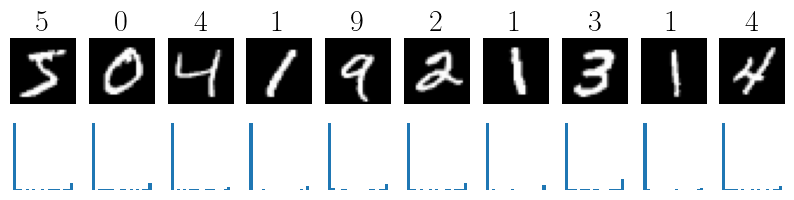

In [8]:
import matplotlib.pyplot as plt

X_numpy = X.to_numpy()
X_numpy = X_numpy.astype(np.float32)
X_numpy /= np.max(X_numpy)
N_features = X_numpy.shape[1]
N_samples = X_numpy.shape[0]
X_reshaped = np.reshape(X_numpy, (N_samples, 28, 28))

fig, axes = plt.subplots(2,10,figsize=(10, 2))
axes = axes.flatten()

for i, ax in enumerate(axes[:10]):
    ax.imshow(X_reshaped[i,:,:], cmap='gray')
    ax.axis('off')
    ax.set_title(f'{y[i]}')

for i, ax in enumerate(axes[10:]):
    ax.hist(X_reshaped[i,:,:].flatten(), bins=np.linspace(0,1,20))
    ax.axis('off')
plt.show()




PCA simplifies the data lowering the dimensions in latent variables. Latent variables are unobservable but can be directly computed from the feature data that we have. In this case, our data has $N_{\text{features}}=784$. 

The mean feature vector ($N_{\text{samples}} \times N_{\text{features}}  = 70000 \times 784$) is computed as

\begin{equation}
\overline{x} = \frac{1}{N} \sum_i^{N_{\text{samples}}} {X_i} 
\end{equation}

Let's consider a normalized vector $u$ in feature space $u u^T = 1$. We can compute the mean projected data by multiplying $u \overline{x}$

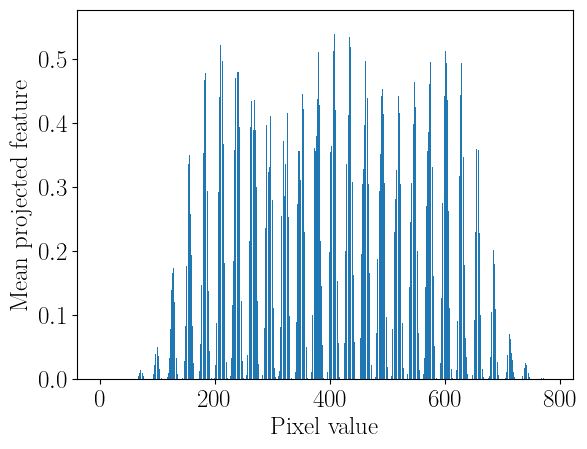

In [9]:
mean_projected = np.mean(X_numpy, axis=0)
plt.bar(np.arange(N_features), mean_projected)
plt.xlabel('Pixel value')
plt.ylabel('Mean projected feature')
plt.show()


If we assume any $u$ vector in the feature space, the variance of the projected data can be described by:

\begin{equation}
f(u) = \frac{1}{N_{\text{samples}}} \sum_{i=1}^{N_{\text{samples}}} (u x_i - u \overline{x})^2 = u^T S u, 
\end{equation}
where 
\begin{equation}
S = \frac{1}{N_{\text{samples}}} \sum_{i=1}^{N_{\text{samples}}} (x_i - \overline{x}) (x_i - \overline{x})^T
\end{equation}.

Maximizing $\frac{df}{du}$ while enforcing $uu^T=1$:

\begin{equation}
 \frac{df}{du} = 0 = Su - \lambda u
\end{equation}

From this it is shown that $u$ is the eigenvector of S and $\lambda$ the eigenvalue

(784, 784)


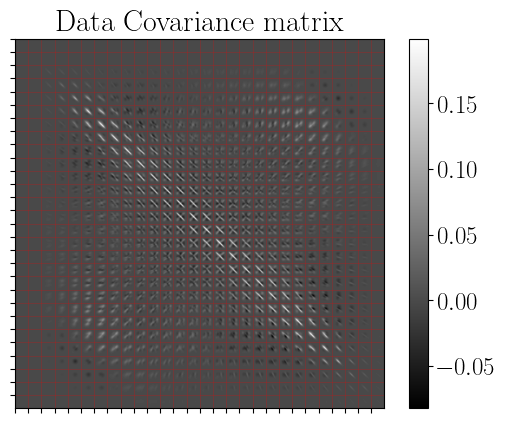

In [10]:
X_numpy_centered = X_numpy - np.mean(X_numpy, axis=0)
X_numpy_centered_T = X_numpy_centered.T


S = np.matmul(X_numpy_centered_T, X_numpy_centered)
S /= N_samples

print(S.shape)

#visualize matrix
plt.imshow(S, cmap='gray')
plt.title('Data Covariance matrix')
plt.colorbar()
plt.grid(True, which='both', color='red', linewidth=0.5, alpha=0.3)
plt.xticks(np.arange(0, 784, 28),labels=[])
plt.yticks(np.arange(0, 784, 28),labels=[])
plt.show()#plot a grid for each pixel
#turn off x tick labels



Note that the data covariance is a matrix of $N_{\text{features}} \times N_{\text{features}}$, showing the covariance between the different pixels of the images. We can see high covariance in the diagonal (close pixels) while less covariance on the edges (pixels far apart). The cross pattern observed is because vertical and horizontal pixels have high covariance. 

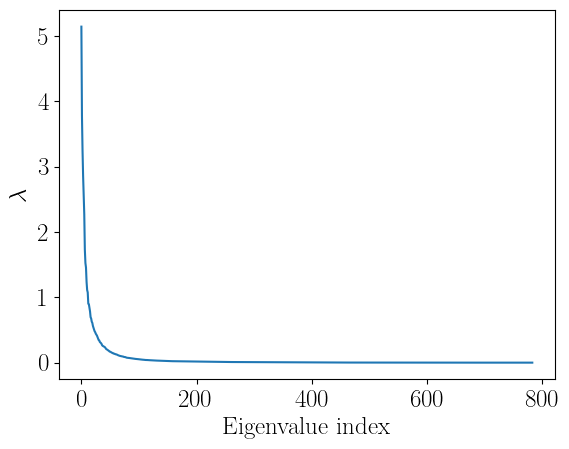

In [11]:
def compute_pca(S):
    # Force symmetry to avoid numerical issues
    S = (S + S.T) / 2
    # Use eigh instead of eig for symmetric matrices
    eigenvalues, eigenvectors = np.linalg.eigh(S)
    # Sort in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues_sorted = eigenvalues[idx]
    eigenvectors_sorted = eigenvectors[:, idx]
    return eigenvalues_sorted, eigenvectors_sorted

eigenvalues_sorted, eigenvectors_sorted = compute_pca(S)

#Plot the eigenvalues
plt.plot(eigenvalues_sorted)
plt.xlabel('Eigenvalue index')
plt.ylabel('$\lambda$')
plt.show()

We can now reduce the dimensionality of the images by $M<D$ where $D$ is the original feature dimensionality. The PCA can be then reconstructed to match the same dimensions while adding the mean feature values. Note that because we have multiple digits in the dataset we need a high $M$ to visualize the digit

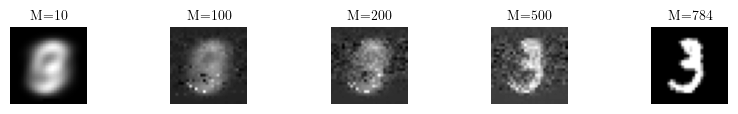

In [12]:
M = [10,100,200,500,784]
fig, ax = plt.subplots(1,len(M),figsize=(10,1))
ax = ax.flatten()
for i,m in enumerate(M):
    U = eigenvectors_sorted[:m].T
    X_pca_reduced = np.matmul(X_numpy_centered, U)
    X_pca_reconstructed = np.matmul(X_pca_reduced, U.T) + np.mean(X_numpy, axis=0)
    X_pca_reconstructed_reshaped = np.reshape(X_pca_reconstructed, (N_samples, 28, 28))    
    ax[i].imshow(X_pca_reconstructed_reshaped[10,:,:], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'M={m}',fontsize=10)
plt.show()

Let's filter only the digit 3 from the database and reproduce the same PCA and plot

In [13]:
y_numpy = y.to_numpy()
y_numpy_3 = y_numpy[y_numpy == "3"]
x_numpy_3 = X_numpy[y_numpy == "3"]
print(x_numpy_3.shape,y_numpy_3.shape)

(7141, 784) (7141,)


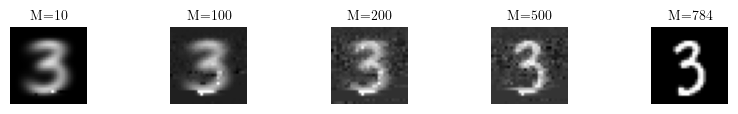

In [19]:
X_numpy_3_centered = x_numpy_3 - np.mean(x_numpy_3, axis=0)
X_numpy_3_centered_T = X_numpy_3_centered.T

S_3 = np.matmul(X_numpy_3_centered_T, X_numpy_3_centered)
S_3 /= x_numpy_3.shape[0]
N_samples_3 = x_numpy_3.shape[0]

eigenvalues_3_sorted, eigenvectors_3_sorted = compute_pca(S_3)
M = [10,100,200,500,784]
fig, ax = plt.subplots(1,len(M),figsize=(10,1))
ax = ax.flatten()
for i,m in enumerate(M):
    U = eigenvectors_3_sorted[:m].T
    X_pca_reduced = np.matmul(X_numpy_3_centered, U)
    X_pca_reconstructed = np.matmul(X_pca_reduced, U.T) + np.mean(x_numpy_3, axis=0)
    X_pca_reconstructed_reshaped = np.reshape(X_pca_reconstructed, (N_samples_3, 28, 28))    
    ax[i].imshow(X_pca_reconstructed_reshaped[10,:,:], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'M={m}',fontsize=10)
plt.show()
